# Movie Recommendations task
Unlike in the first task, this task is not about producing a fancy report, but rather an exploratory and experimental activity of a more independent nature. The task was to create a machine-learning model that recommends movies. At first to explore the data, then to build a model.
There was an option between developing a model of one's own, and using a more traditional technique for recommendations: either content-filtering or collaborative-filtering. As collaborative-filtering can offer more diverse recommendations, and suggest movies that the user might not otherwise have found (according to both Wikipedia and ChatGPT), this technique was chosen initially.

As we will see, the results were less than satisfactory with that model, which is why content based filtering was implemented later instead.

## EDA 

In [26]:
import pandas as pd
import numpy as np

# Load the data
movie_df = pd.read_csv('moviedata/movies.csv', header=0)
rating_df = pd.read_csv('moviedata/ratings.csv', header=0)

In [27]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Already in this stage collaborative filtering was in mind, which is why the title was imported into the `rating_df`:

In [28]:
rating_df['title'] = rating_df['movieId'].map(movie_df.set_index('movieId')['title'])

In [29]:
rating_df.head()

,userId,movieId,rating,timestamp,title
0,1,296,5.0,1147880044,Pulp Fiction (1994)
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994)
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993)
3,1,665,5.0,1147878820,Underground (1995)
4,1,899,3.5,1147868510,Singin' in the Rain (1952)


Checking how many unique movie titles are in the dataframe:

In [30]:
rating_df['title'].nunique()

58958

To get a more reasonably sized model, 1M rows were sampled out of the 25M. 

In [31]:
smaller_df = rating_df.sample(n=1000000, random_state=1)
smaller_df.shape

(1000000, 5)

Check how many unique movies are in this smaller subset:

In [32]:
smaller_df['title'].nunique()

23166

Check how many unique movies with 5 star ratings:

In [33]:
smaller_df[(smaller_df['rating'] == 5)]['title'].value_counts()

title
Shawshank Redemption, The (1994)             1617
Pulp Fiction (1994)                          1282
Schindler's List (1993)                      1072
Star Wars: Episode IV - A New Hope (1977)    1061
Forrest Gump (1994)                          1021
                                             ... 
Another Cinderella Story (2008)                 1
D.C.H. (Dil Chahta Hai) (2001)                  1
Peacemaker, The (1997)                          1
Prison Break: The Final Break (2009)            1
Biutiful (2010)                                 1
Name: count, Length: 8600, dtype: int64

8600 unique movie titles with 5 star ratings seemed like it would cover most movies, so it was deemed good enough. The vague idea was to recommend movies based on 5 star ratings.

## Choosing the model

To get an overview of the difference between the different approaches, ChatGPT was consulted. The comparison shows that Collaborative Filtering probably would be the best choice for this domain, which is also what was suspected after reading up on the two models on Wikipedia:  

*ChatGPT4: Comparing Content Filtering and Collaborative Filtering:*

| Feature                         | Content Filtering                                   | Collaborative Filtering                                      |
|---------------------------------|-----------------------------------------------------|--------------------------------------------------------------|
| **Data Required**               | Item features (e.g., genre, author)                  | User-item interactions (e.g., ratings, views)                |
| **Recommendation Basis**        | Similarity between item features and user preferences| Similarity between users or items based on user interactions |
| **Advantages**                  | - Privacy-friendly <br> - Can recommend new items <br> - Transparent reasoning      | - Diverse recommendations <br> - Can discover serendipitous items <br> - Effective without item metadata            |
| **Limitations**                 | - Limited by item features <br> - Risk of over-specialization <br> - Cold start problem for new users | - Cold start problem for new users/items <br> - Requires large amounts of data <br> - Scalability issues            |
| **Application Examples**        | - E-commerce product recommendations <br> - Online libraries and content platforms | - Movie, music, and book recommendations <br> - E-commerce and social networking sites                             |
| **User/Item Newness Handling**  | Can handle new items if item features are available  | Struggles with new users and items due to lack of interaction data                                                 |
| **Diversity of Recommendations**| May recommend items too similar to user's past likes | Generally offers more diverse recommendations                |
| **Requirement for Metadata**    | High (needs detailed item features)                   | Low (relies on user behavior rather than item specifics)      |

Thus, as already stated, **Collaborative Filtering** was chosen initially. 

ChatGPT suggested to use **Singular Value Decomposition (SVD)** to handle the sparse data and the large number of rows to implement a specific item based Collaborative Filtering method. As it was one of the methods also mentioned in the [Wikipedia article](https://en.wikipedia.org/wiki/Collaborative_filtering), and for a lack of further domain knowledge, that's what was developed.

## Collaborative filtering
As user ratings of the movies is the foundation of this method, some things were immediately clear: 
- To ignore tags.csv, links.csv
- From movies.csv use `title` column, in ratings.csv all columns.

Also, a random subset needed to be selected to perform the training as 25,000,000 ratings are quite a lot (as done above already).

### Theory
*ChatGPT explains SVD in brief:*

Singular Value Decomposition (SVD) is a technique that decomposes a matrix $A$ (representing user ratings for movies) into three matrices: $U$ (user feature vectors), $\Sigma$ (a diagonal matrix of singular values ranking latent feature importance), and $V^{T}$ (item feature vectors in movies). 

The decomposition, $A = U \Sigma V^{T}$, reveals hidden user and item characteristics and patterns in ratings. The singular values in $\Sigma$ assess the significance of each latent feature. By retaining only the top features, SVD simplifies user-item interactions, aiding in the prediction of unseen item ratings based on latent features.

### Implementing the model

Apparently, there was need for an additional package called `scikit-surprise` to use a ready built package for Singular Value Decomposition. As it was not possible to install `scikit-surprise` using `pip`, an environment was created using `conda`, where the required packages were installed.

The data was loaded into the SVD and 5-fold Cross Validation was performed to evaluate the results:

In [34]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

# Load the dataset into Surprise's format. As is was so fast, we could use the full dataset. 
# model.fit() on the full dataset runs in just under 14 minutes on an 8 year old laptop.
# But due to the size of the pickle file, and execution time at use, the smaller dataset of 1M rows was used.

reader = Reader(rating_scale=(min(smaller_df['rating']), max(smaller_df['rating'])))
data = Dataset.load_from_df(smaller_df[['userId', 'movieId', 'rating']], reader)

model = SVD()

# Perform 5-fold cross-validation to check results
results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=-2)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9162  0.9147  0.9177  0.9184  0.9155  0.9165  0.0014  
MAE (testset)     0.7058  0.7040  0.7063  0.7061  0.7050  0.7054  0.0008  
Fit time          22.72   23.15   22.00   15.69   14.75   19.66   3.66    
Test time         4.42    5.26    4.85    3.32    2.43    4.06    1.04    


With an RMSE consistently at 0.92 (rounded) it seemed to be doing very well (although perhaps being a bit too consistent?). Next, split the data into a training set and a test set, to avoid data leakage, for later use, and check RMSE: 

In [35]:
# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train the model on the training set
model.fit(trainset)

# Predict ratings for the test set
predictions = model.test(testset)

# Evaluate the predictions
rmse = accuracy.rmse(predictions)

RMSE: 0.9184


Also this time the RMSE on the testset is at 0.92. 

It was time to implement the recommendations. - Are we going to be blown away by this great model, or what?
### Putting the model to the test
Here's a function for entering favorite movie titles:

In [1]:
# Separated this out to be able to use it later also
def enter_favorite_movies():
    user_favorites_titles = []
    print("Enter your favorite movies (press enter to finish):")
    while True:
        title_input = input()
        if title_input == "":
            break
        user_favorites_titles.append(title_input)
    return user_favorites_titles

The code below finds the `movie_id`'s. There are some limitations to this model, as it returns all movies containing the strings from the user input. E.g. if you enter "Matrix", all movies with that word will be returned. However, for an initial building of a model it was deemed good enough.

In [41]:
user_favorites_titles = enter_favorite_movies()

favorite_movie_ids = []

for user_title in user_favorites_titles:
    matches = movie_df[movie_df['title'].str.contains(user_title, case=False, na=False)]
    if not matches.empty:
        for _, row in matches.iterrows():
            favorite_movie_ids.append(row['movieId'])
            print(f"Found: {row['title']} with ID: {row['movieId']}")
    else:
        print(f"No matches found for: {user_title}")

print("Your favorite movie IDs:", favorite_movie_ids)


Enter your favorite movies (press enter to finish):
Found: Matrix, The (1999) with ID: 2571
Found: Matrix Reloaded, The (2003) with ID: 6365
Found: Matrix Revolutions, The (2003) with ID: 6934
Found: Animatrix, The (2003) with ID: 27660
Found: Return to Source: The Philosophy of The Matrix (2004) with ID: 132490
Found: Armitage: Dual Matrix (2002) with ID: 157721
Found: The Matrix Revisited (2001) with ID: 172255
Found: The Living Matrix (2009) with ID: 179489
Found: Matrix of Evil (2003) with ID: 181103
Your favorite movie IDs: [2571, 6365, 6934, 27660, 132490, 157721, 172255, 179489, 181103]


Here the user enters some favorite movies and gets recommendations. To get the `predicted_ratings` and finding out how to get those values, the debugger was used to inspect the `predictions` variable. For some reason the interactivity seemed to make it more fun than to just hardcode the movie titles.

In [42]:
new_user_id = 'new_user'  

all_movie_ids = set(smaller_df['movieId'].unique())

# Exclude movies that the new user has listed as their favorites
movies_to_predict = list(all_movie_ids - set(favorite_movie_ids))

# Create a list of tuples in the form of (new_user_id, movieId, actual_rating)
# Since we don't have actual ratings for these, we use a dummy rating value of 5
testset = [[new_user_id, movie_id, 5.] for movie_id in movies_to_predict] 

# Predict ratings for all movies the new user hasn't rated
predictions = model.test(testset)

# Convert predictions to a list of (movieId, predicted_rating) tuples
predicted_ratings = [(pred.iid, pred.est) for pred in predictions]

# Sort the predictions by estimated rating in descending order
predicted_ratings.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 recommendations
top_recommendations = predicted_ratings[:10]

print("Top 10 movie recommendations for you:")
print("=====================================")
i=1
for movie_id, rating in top_recommendations:
    movie_name = movie_df.loc[movie_df['movieId'] == movie_id, 'title'].values[0]
    print(f"{i}) {movie_name}, Predicted Rating: {rating:.1f}")
    i += 1

# Get the top 10 movies to stay away from
bottom_recommendations = predicted_ratings[-10:]

i=10
print("\nTop 10 movies for you to avoid:")
print("##############################################")
for movie_id, rating in bottom_recommendations:
    movie_name = movie_df.loc[movie_df['movieId'] == movie_id, 'title'].values[0]
    print(f"{i}) {movie_name}, Predicted Rating: {rating:.1f}")
    i -= 1


Top 10 movie recommendations for you:
1) Planet Earth II (2016), Predicted Rating: 4.6
2) Band of Brothers (2001), Predicted Rating: 4.6
3) Planet Earth (2006), Predicted Rating: 4.5
4) Children of Paradise (Les enfants du paradis) (1945), Predicted Rating: 4.5
5) To Live (Huozhe) (1994), Predicted Rating: 4.4
6) Exterminating Angel, The (Ángel exterminador, El) (1962), Predicted Rating: 4.4
7) Song of the Little Road (Pather Panchali) (1955), Predicted Rating: 4.4
8) Shawshank Redemption, The (1994), Predicted Rating: 4.4
9) Harakiri (Seppuku) (1962), Predicted Rating: 4.4
10) There Once Was a Dog (1982), Predicted Rating: 4.4

Top 10 movies for you to avoid:
##############################################
10) Baby Geniuses (1999), Predicted Rating: 2.0
9) Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002), Predicted Rating: 1.9
8) Kazaam (1996), Predicted Rating: 1.9
7) Pokémon 3: The Movie (2001), Predicted Rating: 1.9
6) Glitter (2001), Predicted Rating: 1.9
5) Problem Child 2 (199

Saving the model (skipping as the file is useless and takes up too much space):

In [41]:
from joblib import dump, load
# dump(model, './save/SVD_movie_model_1M.pkl', compress=5)

['./save/SVD_movie_model_1M.pkl']

### Issue
This looks all good at first glance. There is a slight drawback though: **the recommendations are always the same**. 

The reasons for this eluded the author, suspecting it might have something to do with the `user_id` feature (but then why would it have such a great impact?), or the sparse interaction of users given the totality of movies? In the end, the author couldn't think of a way to get around it, and figured that the gods might be more favorable to implementing content based filtering instead.

## Content based filtering
Due to the poor handling of the sparse dataset by the above model, here's a go at content based filtering.
First, there's now a need to include the metadata consisting of the genre discriptions and the user provided tags.

In [76]:
import pandas as pd
import numpy as np

movie_df = pd.read_csv('moviedata/movies.csv', header=0)
rating_df = pd.read_csv('moviedata/ratings.csv', header=0)
tag_df = pd.read_csv('moviedata/tags.csv', header=0)

aggregated_tags_df = tag_df.groupby('movieId')['tag'].agg(list).reset_index()

# Merge the aggregated tags into the movie_df
movie_df_with_tags = pd.merge(movie_df, aggregated_tags_df, on='movieId', how='left')

movie_df_with_tags

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Owned, imdb top 250, Pixar, Pixar, time trave..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Robin Williams, time travel, fantasy, based o..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"[funny, best friend, duringcreditsstinger, fis..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[based on novel or book, chick flick, divorce,..."
4,5,Father of the Bride Part II (1995),Comedy,"[aging, baby, confidence, contraception, daugh..."
...,...,...,...,...
62418,209157,We (2018),Drama,NaN
62419,209159,Window of the Soul (2001),Documentary,NaN
62420,209163,Bad Poems (2018),Comedy|Drama,NaN
62421,209169,A Girl Thing (2001),(no genres listed),NaN


Checking proportion of movies without tags

In [3]:
movie_df_with_tags['tag'].isna().sum(), movie_df_with_tags.shape

(17172, (62423, 4))

Create `metadata` column to avoid `NaN` values and only have one feature for all metadata.

In [77]:
# Ensure 'genres' is a string.
movie_df_with_tags['genres'] = movie_df_with_tags['genres'].astype(str)
# Lambda function handles NaN values and ensures all items are treated as strings (needed ChatGPT for this one)
movie_df_with_tags['tag'] = movie_df_with_tags['tag'].apply(lambda x: ', '.join([str(tag) for tag in x]) if isinstance(x, list) else '')

# Concatenate 'genres' and 'tag' into a 'metadata' column
movie_df_with_tags['metadata'] = movie_df_with_tags['genres'] + ' ' + movie_df_with_tags['tag'].str.strip()

In [78]:
# Strip metadata of , and | characters
movie_df_with_tags['metadata'] = movie_df_with_tags['metadata'].str.replace('|', ' ')
movie_df_with_tags['metadata'] = movie_df_with_tags['metadata'].str.replace(',', ' ')

In [79]:
movie_df_with_tags

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Owned, imdb top 250, Pixar, Pixar, time travel...",Adventure Animation Children Comedy Fantasy Ow...
1,2,Jumanji (1995),Adventure|Children|Fantasy,"Robin Williams, time travel, fantasy, based on...",Adventure Children Fantasy Robin Williams tim...
2,3,Grumpier Old Men (1995),Comedy|Romance,"funny, best friend, duringcreditsstinger, fish...",Comedy Romance funny best friend duringcredi...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"based on novel or book, chick flick, divorce, ...",Comedy Drama Romance based on novel or book c...
4,5,Father of the Bride Part II (1995),Comedy,"aging, baby, confidence, contraception, daught...",Comedy aging baby confidence contraception ...
...,...,...,...,...,...
62418,209157,We (2018),Drama,,Drama
62419,209159,Window of the Soul (2001),Documentary,,Documentary
62420,209163,Bad Poems (2018),Comedy|Drama,,Comedy Drama
62421,209169,A Girl Thing (2001),(no genres listed),,(no genres listed)


Checking that there are no missing values:

In [5]:
movie_df_with_tags['metadata'].isna().sum()

0

Drop `genres`, `tag` columns to slim dataframe:

In [80]:

movie_df_with_tags = movie_df_with_tags.drop(columns=['genres', 'tag'])

### Choosing the method: TF-IDF
When researching how to usually implement a content based filtering model, I quickly stumbled upon the TF-IDF method, and decided to give it a go, as cosine similarity is a familiar concept, and the name had been mentioned during several lectures. The Sklearn library also seemed pretty straight forward [(Documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

The first step was to fit and transform the TF-IDF Vectorizer on the metadata, for it to learn the vocabulary and then convert it to numerical form. 

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Skip separators and lowercase the text
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words=[',','|'])

In [82]:
# Fit and transform the metadata to TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(movie_df_with_tags['metadata'])

To get more of a feel for what the vectorization did, let's inspect the TF-IDF Vectorizer and the matrix output: 

In [83]:
tfidf_vectorizer.vocabulary_

{'adventure': 657,
 'animation': 1424,
 'children': 5767,
 'comedy': 6477,
 'fantasy': 10919,
 'owned': 23409,
 'imdb': 15335,
 'top': 32525,
 '250': 208,
 'pixar': 24552,
 'time': 32316,
 'travel': 32826,
 'funny': 12127,
 'witty': 35178,
 'rated': 26112,
 'computer': 6609,
 'good': 12985,
 'cartoon': 5179,
 'chindren': 5788,
 'friendship': 11985,
 'bright': 4280,
 'daring': 7792,
 'rescues': 26664,
 'fanciful': 10895,
 'heroic': 14324,
 'mission': 20999,
 'humorous': 14990,
 'light': 18546,
 'rousing': 27383,
 'toys': 32669,
 'come': 6464,
 'to': 32401,
 'life': 18526,
 'unlikely': 33559,
 'friendships': 11986,
 'warm': 34585,
 'disney': 8778,
 'boy': 4065,
 'next': 22260,
 'door': 9076,
 'bullying': 4563,
 'friends': 11984,
 'jealousy': 16329,
 'martial': 19851,
 'arts': 1935,
 'neighborhood': 22109,
 'new': 22220,
 'toy': 32663,
 'rescue': 26661,
 'resourcefulness': 26700,
 'rivalry': 27043,
 'comes': 6481,
 'walkie': 34509,
 'talkie': 31586,
 'clever': 6143,
 'tom': 32461,
 'hanks

Apparently all words in the vocabulary were used as features (see below, where `feature_names` are the features extracted from the corpus). This seemed a bit odd, but deemed to be something to deal with later if the results were to be unsatisfactory.

In [84]:
voclen = len(tfidf_vectorizer.vocabulary_)
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"Vocabulary length: {voclen}\nFeature length: {len(feature_names)}")

Vocabulary length: 36025
Feature length: 36025


Checking the most and least frequent words (the debugger and documentation were used to find out how to get to the values):

In [9]:
idf_values = tfidf_vectorizer.idf_
idf_dict = dict(zip(feature_names, idf_values))
sorted_idf = sorted(idf_dict.items(), key=lambda x: x[1])

print("Lowest IDF values (most common terms):")
print(sorted_idf[:10])

print("\nHighest IDF values (least common terms):")
print(sorted_idf[-10:])

Lowest IDF values (most common terms):
[('drama', 1.8791664536078412), ('comedy', 2.276158644373692), ('thriller', 2.95161329641659), ('romance', 3.0088181492175083), ('action', 3.092080348042381), ('horror', 3.3113378841036405), ('crime', 3.380238415223935), ('documentary', 3.385619905513741), ('no', 3.4095773662882602), ('genres', 3.5117931319725852)]

Highest IDF values (least common terms):
[('惊悚', 11.348557915236652), ('扭曲', 11.348557915236652), ('斯巴达克斯', 11.348557915236652), ('淘金记', 11.348557915236652), ('独闯龙潭', 11.348557915236652), ('竞技场之神', 11.348557915236652), ('臥底', 11.348557915236652), ('莫声版', 11.348557915236652), ('魔鬼司令', 11.348557915236652), ('카운트다운', 11.348557915236652)]


Apparently, some chinese words are included in the vocabulary, constituting the least common terms. 

Next to be explored to get a feel for how well it captures what is special about a particular movie: What are the TF-IDF scores for the movie with a specified index number?

In [12]:
def print_tfidf_scores(doc_index):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix[doc_index].toarray().flatten()
    
    scores_dict = dict(zip(feature_names, tfidf_scores))
    sorted_scores = sorted(scores_dict.items(), key=lambda x: x[1], reverse=True)
    
    for term, score in sorted_scores:
        if score > 0:
            print(f"{term}: {score}")

# According to movie_df.head() index 1 is "Jumanji"
print_tfidf_scores(1)


robin: 0.5446167136607799
williams: 0.5121227672667045
board: 0.2920345565561034
game: 0.24535226462132634
time: 0.2257176790211587
travel: 0.22426969548899756
animals: 0.18892492557180915
fantasy: 0.1841419060632971
cgi: 0.15610941156195504
kid: 0.11901695063268322
flick: 0.11687951873875763
scary: 0.11325956282652598
bad: 0.08138703201423816
dunst: 0.07531870707143819
kirsten: 0.07448789483781622
magic: 0.06360251108349665
children: 0.05993814149032501
kids: 0.054416420120817835
book: 0.05359588577004541
family: 0.048878009765698865
for: 0.04791134950633545
herds: 0.046441238547714675
recaptured: 0.046441238547714675
not: 0.0446225018349652
johnston: 0.04130411157874487
adventure: 0.03997129264894706
monkey: 0.033276821319161896
joe: 0.031201831471880374
childhood: 0.02712967702839731
fiction: 0.026686060681343323
of: 0.02542277467377018
zathura: 0.02473114826061427
based: 0.024301448984561255
lebbat: 0.02384754544710914
on: 0.023344585212458423
allsburg: 0.023220619273857337
adapted

#### Initial evaluation
This method so far seemed to be performing really well. In the example movie above *("Jumanji")* the top words are `Robin Williams board game time travel`. which is probably some of the top words most humans would use to describe the movie.

At a later stage, the average rating of a movie will become relevant, so creating such a feature here:

In [103]:
ratings_df = pd.read_csv('moviedata/ratings.csv', header=0)

# Calculate the average rating for each movie
average_ratings = ratings_df.groupby('movieId')['rating'].mean().reset_index()

# Merge the average ratings into the movie_df
movie_df_with_tags = pd.merge(movie_df_with_tags, average_ratings, on='movieId', how='left')
movie_df_with_tags.shape

# forget ratings_df to save memory
del ratings_df

(62423, 7)

In [104]:
movie_df_with_tags

,movieId,title,genres,tag,metadata,cluster,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Owned, imdb top 250, Pixar, Pixar, time travel...",Adventure|Animation|Children|Comedy|Fantasy Ow...,223,3.893708
1,2,Jumanji (1995),Adventure|Children|Fantasy,"Robin Williams, time travel, fantasy, based on...","Adventure|Children|Fantasy Robin Williams, tim...",356,3.251527
2,3,Grumpier Old Men (1995),Comedy|Romance,"funny, best friend, duringcreditsstinger, fish...","Comedy|Romance funny, best friend, duringcredi...",176,3.142028
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"based on novel or book, chick flick, divorce, ...","Comedy|Drama|Romance based on novel or book, c...",41,2.853547
4,5,Father of the Bride Part II (1995),Comedy,"aging, baby, confidence, contraception, daught...","Comedy aging, baby, confidence, contraception,...",300,3.058434
...,...,...,...,...,...,...,...
62418,209157,We (2018),Drama,NaN,Drama,6,1.500000
62419,209159,Window of the Soul (2001),Documentary,NaN,Documentary,5,3.000000
62420,209163,Bad Poems (2018),Comedy|Drama,NaN,Comedy|Drama,21,4.500000
62421,209169,A Girl Thing (2001),(no genres listed),NaN,(no genres listed),2,3.000000


In [140]:
movie_df_with_tags['rating'].isna().sum()

0

In [139]:
movie_df_with_tags['rating'].fillna(0, inplace=True)


#### Next step: Cosine similarity
Below, we get familiar with how to calculate cosine similarities between movies to get a feel for how it works. Getting the slicing to work with `cosine_similarity()` took some figuring out, instead of just being able to use the index directly (the method requires a 2D matrix, not an array).

In [85]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between the first and second movie
similarity_matrix = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
similarity_matrix


array([[0.05164751]])

As that was otherwise pretty straight forward, the next step was to go for the full shebang by getting movie recommendations based on the users' favorite movies:

In [7]:
# Vstack stacks sparse matrices (where most elements are 0) vertically. Further explained below.
from scipy.sparse import vstack
import re

Below are the functions to get movie indices based on titles, and recommendations based on entered movie titles:

In [151]:
def get_movie_indices(favorite_movie_titles):
    favorite_movie_indices = []
    for title in favorite_movie_titles:
        # Matches whole words (regex \b) to exclude some potential non-intended matches
        matched_indices = movie_df_with_tags.index[movie_df_with_tags['title'].str.contains(r'\b' + re.escape(title) + r'\b', case=False, regex=True)]
        if not matched_indices.empty:
            # Further narrowing it down by only taking the first match if there are multiple matches
            # This would then make it possible for it to recommend other movies in e.g. a trilogy.
            favorite_movie_indices.append(matched_indices[0])
        else:
            print(f"Warning: '{title}' not found in the movie database.")
    return favorite_movie_indices

def get_content_based_recommendations(movie_df_with_tags, favorite_movie_titles, tfidf_matrix, num_recommendations=10, min_rating=0, keywords=None):
    # Assuming get_movie_indices is defined elsewhere and correctly returns indices of favorite movies
    favorite_movie_indices = get_movie_indices(favorite_movie_titles)
    if not favorite_movie_indices:
        return "No favorite movies found in the dataset."
    
    # Generate user profile from favorite movies
    # This section was problematic to get working and eventually I had to resort to asking ChatGPT to solve it,
    # that also needed a couple of rounds. The issue was that the sparse matrix was not being converted to a dense array,
    # and thus not accepted by the cosine_similarity function.
    user_profile = vstack([tfidf_matrix[index] for index in favorite_movie_indices]).mean(axis=0)
    user_profile_dense = user_profile.A 

    # Compute cosine similarities between user profile and all movies
    cosine_similarities = cosine_similarity(user_profile_dense, tfidf_matrix).flatten()

    # Create a series with the similarities scores, index matching the movie DataFrame
    similarities_series = pd.Series(cosine_similarities, index=movie_df_with_tags.index)

    # Sort the movies based on similarity score, in descending order
    sorted_similarities = similarities_series.sort_values(ascending=False)

    recommended_movie_indices = []
    for idx in sorted_similarities.index:
        # Skip the favorite movies
        if idx in favorite_movie_indices:
            continue
        
        # Check the movie rating. This was inserted towards the end of this endeavour, to also include collaboration based filtering.
        movie_rating = movie_df_with_tags.at[idx, 'rating']
        movie_metadata = movie_df_with_tags.at[idx, 'metadata']
        
        # Check the movie rating
        if movie_rating >= min_rating:
            # Check if keywords are specified and if metadata contains any of the keywords
            if keywords:
                # Ensure keywords is a list for proper iteration, even if it's a single keyword
                if isinstance(keywords, str):
                    keywords = [keywords]
                keyword_match = any(str(keyword).lower() in str(movie_metadata).lower() for keyword in keywords)
            else:
                # If no keywords specified, consider it a match
                keyword_match = True
            
            if keyword_match:
                recommended_movie_indices.append(idx)
                if len(recommended_movie_indices) == num_recommendations:
                    break

    # Get the movie titles for the recommended indices
    recommended_movie_titles = movie_df_with_tags.loc[recommended_movie_indices, 'title'].tolist()
    return recommended_movie_titles

Finally we get to enter our favorite movies and get recommendations:

In [148]:
user_favorites = enter_favorite_movies()
recommendations = get_content_based_recommendations(movie_df_with_tags, user_favorites, tfidf_matrix)

print("\nTop 10 movie recommendations for you:")
print("=====================================")
i=1
for movie in recommendations:
    print(f"{i}) {movie}")
    i += 1

Enter your favorite movies (press enter to finish):

Top 10 movie recommendations for you:
1) Matrix Reloaded, The (2003)
2) Matrix Revolutions, The (2003)
3) Avalon (2001)
4) Tron (1982)
5) Terminal Justice (1996)
6) Game Box 1.0 (2004)
7) Thirteenth Floor, The (1999)
8) Dark City (1998)
9) The Nostalgist (2014)
10) Lawnmower Man, The (1992)


**Evaluation**: This model subjectively works much better than the collaboration based model, and is quite satisfactory.
Some research was done regarding how to evaluate a model such as this, but nothing similar to RMSE or such was found. Instead, it seemed like the best way to evaluate was to see the results in an intented use situation, which has now been done.

Save the trained vectorizer:

In [86]:
from joblib import dump
dump(tfidf_vectorizer, './save/tfidf_vectorizer.pkl', compress=5)

['./save/tfidf_vectorizer.pkl']

In [75]:
from joblib import load
tfidf_vectorizer = load('./save/tfidf_vectorizer.pkl')

### K-Means Clustering

Even though I find the above results most satisfactory, and given that what we want to find are the most similar movies to a set of favorite movies, which is exactly what is done in the above code, there is reason to explore and evaluate more of a machine learning approach using the unsupervised method K-means, in order to also get more diverse recommendations.

Initially just getting it to work, and then to find the best number of clusters for optimum performance. For that the common technique of calculating the silhoutte score was used. 

Frist, trying out K-Means clustering on the TF-IDF matrix (1.5 mins to run on my old laptop):

In [9]:
from sklearn.cluster import KMeans

# This is an arbitrary choice - need to experiment with different values
n_clusters = 200

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(tfidf_matrix)

# Assign the cluster labels to the movies
movie_df_with_tags['cluster'] = kmeans.labels_

Check the number of movies per category:

In [10]:
movie_df_with_tags['cluster'].value_counts()

cluster
164    7777
14     3324
184    2442
5      2331
2      1763
       ... 
7        38
161      37
189      19
65       18
27        8
Name: count, Length: 200, dtype: int64

Text(0, 0.5, 'Number of Clusters')

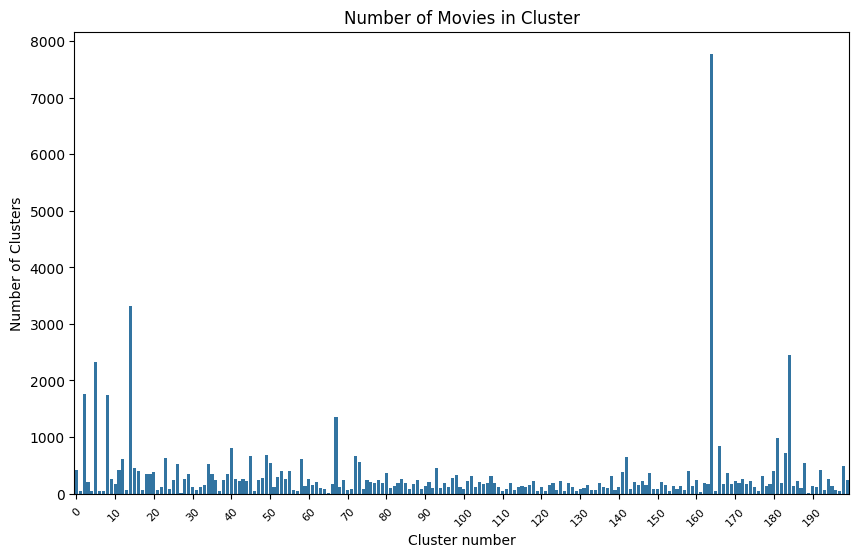

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Plot the distribution of cluster sizes
plt.figure(figsize=(10, 6))
sns.barplot(movie_df_with_tags['cluster'].value_counts())
plt.title('Number of Movies in Cluster')
plt.xlabel('Cluster number')
plt.xticks(rotation=45)
plt.tick_params(axis='x', labelsize=8, labelrotation=45, labelcolor='black', pad=5)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(10))
plt.ylabel('Number of Clusters')

Evaluate best number of clusters using silhouette score (evaluating [20, 50, 100, 200, 300, 400, 500] clusters took some 135 minutes) so beware (also, not possible to stop the run without resetting kernel):

In [21]:
from sklearn.metrics import silhouette_score

n_clusters = [20, 50, 100, 200, 300, 400, 500]
silhouette_avg_list=[]

# Evaluate silhouette scores for the different numbers of clusters
for clusters in n_clusters:
    print("Fitting KMeans with {clusters} clusters")
    kmeans = KMeans(n_clusters=clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_avg_list.append(silhouette_avg)


c:\Users\Mikae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Mikae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Mikae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Mikae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

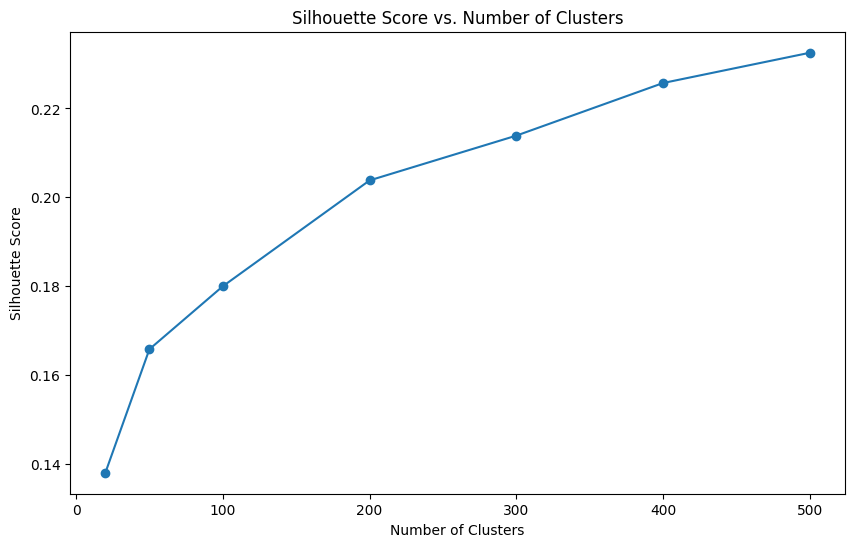

In [22]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, silhouette_avg_list, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

As the curve didn't flatten, and the cost of the calculations in time was pretty large, and to avoid overfitting, while still hopefully having some movies in every category, further explorations whether 500 clusters is enough or too much: 

In [41]:
movie_df_with_tags['cluster'] = kmeans.labels_
movie_df_with_tags['cluster'].value_counts().sort_values(ascending=True).head(50)

cluster
67      1
55      2
141     3
183     4
339     5
40      6
207     6
60      6
102     8
180     9
43      9
201     9
15     10
477    12
42     12
393    13
227    13
342    13
365    14
479    14
331    14
324    14
320    15
281    15
446    15
432    16
209    16
428    16
302    16
197    17
492    17
250    17
109    17
252    18
206    18
408    19
414    19
167    19
473    19
297    19
20     20
404    20
263    20
216    21
498    21
287    21
179    21
460    22
69     23
221    23
Name: count, dtype: int64

The 50 categories with least movies in them still have a decent amount. 12 clusters with less than 10 movies. This is no biggie, as the slicing works even if there are less movies in the category. Unfortunately for the few cool people who want recommendations for category 67, in which there is only one movie, will not get any. But that's a minor issue.

In [45]:
# Finding out which movie is the uncategorizable one in cluster 67, just for fun.
movie_df_with_tags[movie_df_with_tags['cluster'] == 67]

,movieId,title,genres,tag,metadata,cluster
14399,74827,Ajami (2009),Crime|Drama,"Scandar Copti, Yaron Shani, 06/11, 10/10, 11/1...","Crime|Drama Scandar Copti, Yaron Shani, 06/11,...",67


Text(0, 0.5, 'Number of Clusters')

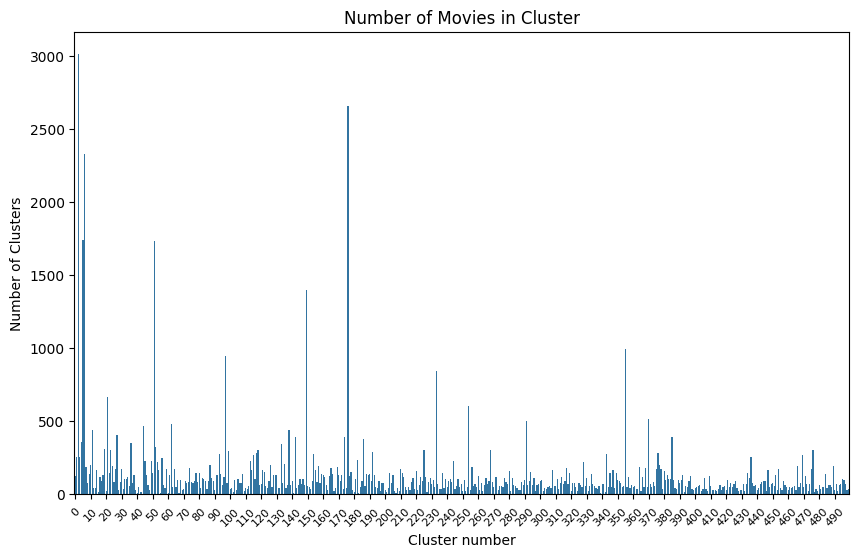

In [39]:
# Plot the distribution of cluster sizes
plt.figure(figsize=(10, 6))
sns.barplot(movie_df_with_tags['cluster'].value_counts())
plt.title('Number of Movies in Cluster')
plt.xlabel('Cluster number')
plt.xticks(rotation=45)
plt.tick_params(axis='x', labelsize=8, labelrotation=45, labelcolor='black', pad=5)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(10))
plt.ylabel('Number of Clusters')

In [47]:
# Check distribution of # of movies per cluster
movie_df_with_tags['cluster'].value_counts().describe()

count     500.000000
mean      124.846000
std       256.277714
min         1.000000
25%        39.000000
50%        69.000000
75%       126.000000
max      3014.000000
Name: count, dtype: float64

The distribution of movies in 500 clusters seems to be ok. Given that there are a couple of clusters with many movies in them, that could be an argument for trying out a larger amount of clusters. But given the time restraints, cost of calculations, and that some categories already don't have that many members, 500 was deemed good enough.

Below, getting a feel for what kind of movies are similar to The Matrix using this method: 

In [38]:
# Check what cluster a specific movie is in
movie_df_with_tags[movie_df_with_tags['title'].str.contains('Matrix')]

# Check what movies are in a specific cluster (Matrix is in cluster 95, which has 58 movies in it)
movie_df_with_tags[movie_df_with_tags['cluster'] == 95]['title']

65               Lawnmower Man 2: Beyond Cyberspace (1996)
196                                    Strange Days (1995)
333                                      Virtuosity (1995)
1014                             Lawnmower Man, The (1992)
1618                                  Sliding Doors (1998)
2015                                           Tron (1982)
2480                                    Matrix, The (1999)
2509                                       eXistenZ (1999)
2580                          Thirteenth Floor, The (1999)
2718                                   Perfect Blue (1997)
2824                                   Total Recall (1990)
3585                                     Flatliners (1990)
3760                                      Cell, The (2000)
4781                                       One, The (2001)
6247                           Matrix Reloaded, The (2003)
6667                                         Avalon (2001)
6809                        Matrix Revolutions, The (200

ChatGPT was asked what these movies have in common: "In summary, these movies are united by their exploration of technology's role in altering human perception, reality, and society, whether through the lens of virtual reality, futuristic dystopias, or speculative technology." - Seems about right.

Saving progress to not have to do the K-means fitting again:

In [91]:
from joblib import dump
# Save the model
dump(kmeans, './save/kmeans_movie_clusters.pkl', compress=5)
dump(cluster_labels, './save/kmeans_movie_cluster_labels.pkl', compress=5)
# Save the movie_df_with_tags based on the clustering
movie_df_with_tags.to_csv('./save/movie_df_with_tags_clustered.csv', index=False)
cluster_labels

In [88]:
# And then to load it again when necessary
from joblib import load
kmeans = load('./save/kmeans_movie_clusters.pkl')
movie_df_with_tags = pd.read_csv('./save/movie_df_with_tags_clustered.csv') 

Function to get movie recommendations based on the K-Means clustering method:

In [136]:
def recommend_movies_based_on_clusters(movie_df_with_tags, favorite_movie_indices, num_recommendations=10, movies_to_exclude=[], min_rating=0, keywords=[]):
    # Find the clusters for the favorite movies
    favorite_clusters = movie_df_with_tags.iloc[favorite_movie_indices]['cluster'].unique()
    
    # Filter movies that are in the same clusters
    recommended_movies = movie_df_with_tags[movie_df_with_tags['cluster'].isin(favorite_clusters)]
    
    # Exclude the favorite movies from the recommendations
    recommendations = recommended_movies[~recommended_movies.index.isin(favorite_movie_indices)]

    # Also exlude movies specified in movies_to_exclude if specified
    if movies_to_exclude:
        recommendations = recommendations[~recommendations['title'].isin(movies_to_exclude)]

    # Exclude movies with a rating below min_rating if specified
    if min_rating > 0:
        recommendations = recommendations[recommendations['rating'] >= min_rating]
    
    # Exclude movies that do not contain the keywords, if specified
    if keywords:
        recommendations = recommendations[recommendations['metadata'].str.contains('|'.join(keywords), case=False, na=False)]
    
    # Randomly pick 'num_recommendations' movies, unless there are not enough movies
    recommendations = recommendations.sample(n=num_recommendations if len(recommendations) > num_recommendations else len(recommendations))
    
    if recommendations.empty:
        return "No recommendations found."

    return recommendations['title'].tolist()

Now to get the recommendations based on this method:

In [93]:
favorite_movie_titles = enter_favorite_movies()
favorite_movie_indices = get_movie_indices(favorite_movie_titles)
recommended_titles = recommend_movies_based_on_clusters(movie_df_with_tags, favorite_movie_indices)

print("\nRecommended movies based on your favorites:")
print("===========================================")
for title in recommended_titles:
    print(title)

Enter your favorite movies (press enter to finish):

Recommended movies based on your favorites:
Lawnmower Man 2: Beyond Cyberspace (1996)
World on a Wire (Welt am Draht) (1973)
Matrix Reloaded, The (2003)
The Call Up (2016)
The Challenge (2003)
Total Recall (1990)
Dungeonmaster, The (1985)
Resurrection of the Little Match Girl (Sungnyangpali sonyeoui jaerim) (2002)
Virtuality (2009)
Seven in Heaven (2018)


It worked as it randomly picked movies from the category the Matrix was categorized as (95).

### Combining

An advantage here is that you can get more diverse recommendations. If you have your set of favorite movies, you might want to get more movies than just the same old 10, if you enter the same movies. But it also means you might not get that similar movies, which makes it tempting to take half of the list from the direct method, and half of the list from K-Means:

In [162]:
favorite_movie_titles = enter_favorite_movies()
print(f"Movies entered: {', '.join(favorite_movie_titles)}\n")

favorite_movie_indices = get_movie_indices(favorite_movie_titles)

rating=3.5
keywords = ['space', 'sci-fi']

# Getting 10 movie recommendations from the content-based approach
recommended_titles = get_content_based_recommendations(movie_df_with_tags, favorite_movie_titles, tfidf_matrix, 5, min_rating=rating, keywords=keywords)

# Getting 5 movie recommendations from the cluster-based approach excluding those recommended by the content-based approach
# With the min_rating set to a voluntary number, to also include some collaborative filtering
kmeans_recommended_titles = recommend_movies_based_on_clusters(movie_df_with_tags, favorite_movie_indices,
                                                                num_recommendations=5, movies_to_exclude=recommended_titles, min_rating=rating, keywords=keywords)


print("Recommended movies based on your favorites:")
print(f"\nMost similar movies with an average rating of at least {rating}" + f"\nand containing any of the keywords: {', '.join(keywords)}" if keywords else "")
print("===========================================================")
for title in recommended_titles:
    print(title)

if kmeans_recommended_titles == "No recommendations found.":
    print("\nNo recommendations found using K-Means based on the search criteria. Consider lowering the minimum rating or use more keywords.")
else:
    print("\nSimilar but not that similar:")
    print("=============================")
    for title in kmeans_recommended_titles:
        print(title)

Enter your favorite movies (press enter to finish):
Movies entered: Matrix

Recommended movies based on your favorites:

Most similar movies with an average rating of at least 3.5
and containing any of the keywords: space, sci-fi
Dark City (1998)
The Nostalgist (2014)
Ghost in the Shell (Kôkaku kidôtai) (1995)
Survivor (1987)
Ex Machina (2015)

Similar but not that similar:
Ready Player One
World on a Wire (Welt am Draht) (1973)
Inception (2010)
Total Recall (1990)


## Summary
For this task, the *Content Based Filtering* using TF-IDF turned out to be much much more adequate than Collaboration Based Filtering. 

For the *Collaboration Filtering*, there were methods to measure RMSE and MAE and get the nice scientific looking metrics to confirm small error rates in the predictions. 5-fold Cross Validation was performed and it seemed very promising.

However, when put to the real test, that of recommending movies based on favorite movies, it always generated the same list of recommendations from top to bottom, no matter which movies were entered as favorite. This is another good example of how metrics are not always indicative of a well performing model. 

This was particularly surprising, as SVD was supposed to be a technique especially well suited for handling sparse matrices. The letdown was so big, that the possibility of implementing another technique than SVD for collaboration filtering did not even occur as a possibility until much later.

**However, the content based approach proved to have several key advantages:**
- It was super quick to fit and transform (3 seconds) and use (0.0 seconds).
- No movies needed to be filtered out, thus a complete coverage.
- Subjectively accurate recommendations, which actually changed (applause) as the inputted movies changed.
- TF-IDF seemed to capture the essence of a movies' characteristics very well, given the available metadata.
- No need to install strange libraries using `conda` that couldn't be installed using `pip`, even after having installed the Microsoft C++ compiler thingy that was recommended to resolve the issue in the `pip` error message.
- Could easily be developed further to recommend movies not just based on the title, but also on key words.

It performed that well, even though there was the somewhat worrying finding that the vectorizer used all words in the vocabulary as features (there was an expectation that not all words would be used).

The results were something of a surprise, given the initial findings during the orientation phase that indicated collaborative filtering would be so much better for this kind of task, and SVD would be well suited to handle this kind of dataset.


### K-Means
K-Means has one big advantage in this context: It allows for clustering and random selection from the clusters to which the favorite movies belong. Given the same favorite movies, the direct method based solely on cosine similarity would in this implementation only show the most similar movies. This, of course, could also be extended to sample a given number of movies from the 100 most similar movies and that would be that.

A drawback with K-Means was that it took quite some time to perform the calculations, and it seems some precision is unnecessarily lost.

### Combining K-Means with direct cosine similarity
Combining the two gave the best of both worlds, so to speak. First a list of the 5 most similar movies, then a random sample of 5 movies from the categories to which the entered movies belong, providing more diverse recommendations than cosine similarity alone would have produced.


As a side note, something no longer included in this notebook was an early exploration of the data frames, that recommended movies directly by selecting data from the data frame ("users who had given 5 star ratings to the entered favorite movies had also given 5 star ratings to these movies"), which took a good minute or two just to comb through the whole data frame before printing the recommendations. That showed how ML can really help speed things up, using way less resources.

### All in all

The task has given insight and experience into how machine-learning algorithms can be used for content recommendations, what some challenges are, and how well TF-IDF performed in this scenario. 

All in all, the project underscored the importance of selecting the right approach for the task at hand, which might not be obvious from the get-go. Especially not as the initial research here indicated something that was then vastly disproven. It also demonstrated the importance of thorough testing, and not relying solely on metrics.